In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Define Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, sub_folder, transform):
        self.root_dir = root_dir
        self.sub_folder = sub_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through the video folders
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)   # DSI_research/video/AM12
                label_file = os.path.join(root_dir, 'Label',f'{video_folder}.xlsx')   #DSI_research/shortaxis_binary.xlsx
                labels_df = pd.read_excel(label_file)

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):   #video_path = DSI_research/video/AM12
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)   #dataset/AM12/0.jpg_xxxxx.jpg
                        # frame_idx = int(os.path.splitext(img_filename)[0]) #splitting 0.jpg and storing 0 to frame_idx
                        root, ext = os.path.splitext(img_filename)  # Split 0.jpg_xxxxx.jpg into root and extension
                        # frame_idx = int(root.split('.')[0]) #splitting 0.jpg_xxxxx and storing 0 to frame_idx
                        labels = labels_df.loc[labels_df['FILENAME']==img_filename, ['BAD QUALITY','CORD','FLUID']].values.astype('float32').squeeze()

                        self.image_paths.append(img_path)
                        self.labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, labels


# Initialize Dataset and Dataloader
def initialize_data(root_dir, sub_folder):
    # Define image transformations
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),])
    train_dataset = CustomDataset(root_dir, sub_folder = sub_folder, transform=transform)
    print('data size:', len(train_dataset))

    # Define the sizes for training, validation, and test sets
    total_size = len(train_dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    # Use random_split to split the dataset
    # torch.cuda.manual_seed_all(0)  # Setting the random seed
    train_subset, val_subset, test_subset = random_split(train_dataset, [train_size, val_size, test_size])

    # Create data loaders for each subset
    batch_size = 64  # Adjust as needed
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Define Model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.resnet(x)

# Train Model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    global num_classes
    global device
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        # Initialize loss and accuracy variables for this epoch
        running_loss = 0.0
        correct_predictions = 0

        # Initialize the progress bar
        train_progress_bar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        for images, labels in train_progress_bar:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(images)
            predicts = (outputs > 0.5).float()
            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss = loss.item()
            running_loss += train_loss * images.size(0)
            correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            train_progress_bar.set_postfix({'Batch Loss': train_loss, 'Batch Accuracy': acc})

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Validation loop
        print('Validation:')
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0

        # Initialize the progress bar for validation
        val_progress_bar = tqdm(val_loader, total=len(val_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        with torch.no_grad():
            for images, labels in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicts = (outputs > 0.5).float()
                acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
                loss = criterion(outputs, labels)

                val_loss = loss.item()
                val_running_loss += val_loss * images.size(0)
                val_correct_predictions += acc * images.size(0)

                # Update the progress bar with the loss and accuracy
                val_progress_bar.set_postfix({'Batch Loss': val_loss, 'Batch Accuracy': acc})
        # Calculate average loss and accuracy for the validation
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = val_correct_predictions / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        print(f'Validation Epoch {epoch+1}/{num_epochs} - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}')
        print('------------------------------------------------------------------------------------------------')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Test Model
def test_model(test_loader, model, criterion):
    global num_classes
    global device
    # Initialize variables to store predictions and true labels
    all_preds = []
    all_labels = []

    # Test loop
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_predictions = 0

    # Initialize the progress bar for testing
    test_progress_bar = tqdm(test_loader, total=len(test_loader), desc='Testing', position=0, leave=True)

    with torch.no_grad():
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicts = (outputs > 0.5).float()

            # Store predictions and true labels for later metrics calculation
            all_preds.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)

            test_loss = loss.item()
            test_running_loss += test_loss * images.size(0)
            test_correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            test_progress_bar.set_postfix({'Batch Loss': test_loss, 'Batch Accuracy': acc})

    # Calculate average loss and accuracy for the test set
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_accuracy = test_correct_predictions / len(test_loader.dataset)

    # Calculate other metrics
    precision = precision_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    recall = recall_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    f1 = f1_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    roc_auc = roc_auc_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())

    print("\n" + "="*50)
    print(f'Test Metrics:')
    print(f'{"-"*50}')
    print(f'Loss      : {test_epoch_loss:.4f}')
    print(f'Accuracy  : {test_epoch_accuracy:.4f}')
    print(f'Precision : {precision:.4f}')
    print(f'Recall    : {recall:.4f}')
    print(f'F1 Score  : {f1:.4f}')
    print(f'ROC AUC   : {roc_auc:.4f}')
    print("="*50)

    # Initialize variables to store class-wise metrics
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_roc_aucs = []

    # Calculate metrics for each class
    num_classes = np.array(all_labels).shape[1]  # Assuming all_labels is a 2D array
    for i in range(num_classes):
        y_true = np.array(all_labels)[:, i]
        y_pred = np.array(all_preds)[:, i]

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred)

        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1)
        class_roc_aucs.append(roc_auc)

        print(f"Metrics for class {i}:")
        print(f"  Precision : {precision:.4f}")
        print(f"  Recall    : {recall:.4f}")
        print(f"  F1 Score  : {f1:.4f}")
        print(f"  ROC AUC   : {roc_auc:.4f}")
        print("-"*20)

    # If you want a summary report
    print("Summary Classification Report:")
    print(classification_report(np.array(all_labels), np.array(all_preds), zero_division=0))

# Main function to run the whole pipeline
def main(root_dir, sub_folder, num_epochs):
    # Initialize Data
    train_loader, val_loader, test_loader = initialize_data(root_dir, sub_folder)

    # Initialize Model, Loss, and Optimizer
    global device
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train Model
    # train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=5)
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Test Model
    test_model(test_loader, model, criterion)


Mounted at /content/drive


data size: 11224


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]
Epoch 1: 100%|██████████| 141/141 [2:08:23<00:00, 54.64s/it, Batch Loss=0.263, Batch Accuracy=0.947]


Epoch 1/10 - Loss: 0.3232, Accuracy: 0.8902
Validation:


Epoch 1: 100%|██████████| 18/18 [15:17<00:00, 51.00s/it, Batch Loss=0.319, Batch Accuracy=0.902]


Validation Epoch 1/10 - Loss: 0.1988, Accuracy: 0.9447
------------------------------------------------------------------------------------------------


Epoch 2: 100%|██████████| 141/141 [01:17<00:00,  1.82it/s, Batch Loss=0.061, Batch Accuracy=0.982]


Epoch 2/10 - Loss: 0.1078, Accuracy: 0.9615
Validation:


Epoch 2: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s, Batch Loss=0.157, Batch Accuracy=0.931]


Validation Epoch 2/10 - Loss: 0.1485, Accuracy: 0.9355
------------------------------------------------------------------------------------------------


Epoch 3: 100%|██████████| 141/141 [01:18<00:00,  1.81it/s, Batch Loss=0.0929, Batch Accuracy=0.965]


Epoch 3/10 - Loss: 0.0616, Accuracy: 0.9781
Validation:


Epoch 3: 100%|██████████| 18/18 [00:07<00:00,  2.32it/s, Batch Loss=0.0947, Batch Accuracy=0.98]


Validation Epoch 3/10 - Loss: 0.1345, Accuracy: 0.9519
------------------------------------------------------------------------------------------------


Epoch 4: 100%|██████████| 141/141 [01:17<00:00,  1.81it/s, Batch Loss=0.00558, Batch Accuracy=1]


Epoch 4/10 - Loss: 0.0455, Accuracy: 0.9833
Validation:


Epoch 4: 100%|██████████| 18/18 [00:07<00:00,  2.32it/s, Batch Loss=0.00914, Batch Accuracy=1]


Validation Epoch 4/10 - Loss: 0.0529, Accuracy: 0.9813
------------------------------------------------------------------------------------------------


Epoch 5: 100%|██████████| 141/141 [01:17<00:00,  1.81it/s, Batch Loss=0.0074, Batch Accuracy=1]


Epoch 5/10 - Loss: 0.0333, Accuracy: 0.9871
Validation:


Epoch 5: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s, Batch Loss=0.00413, Batch Accuracy=1]


Validation Epoch 5/10 - Loss: 0.0405, Accuracy: 0.9860
------------------------------------------------------------------------------------------------


Epoch 6: 100%|██████████| 141/141 [01:18<00:00,  1.81it/s, Batch Loss=0.254, Batch Accuracy=0.912]


Epoch 6/10 - Loss: 0.0246, Accuracy: 0.9910
Validation:


Epoch 6: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s, Batch Loss=0.0218, Batch Accuracy=1]


Validation Epoch 6/10 - Loss: 0.0544, Accuracy: 0.9854
------------------------------------------------------------------------------------------------


Epoch 7: 100%|██████████| 141/141 [01:18<00:00,  1.80it/s, Batch Loss=0.0108, Batch Accuracy=1]


Epoch 7/10 - Loss: 0.0343, Accuracy: 0.9874
Validation:


Epoch 7: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s, Batch Loss=0.0354, Batch Accuracy=0.98]


Validation Epoch 7/10 - Loss: 0.0458, Accuracy: 0.9848
------------------------------------------------------------------------------------------------


Epoch 8: 100%|██████████| 141/141 [01:18<00:00,  1.81it/s, Batch Loss=0.00622, Batch Accuracy=1]


Epoch 8/10 - Loss: 0.0201, Accuracy: 0.9926
Validation:


Epoch 8: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s, Batch Loss=0.00547, Batch Accuracy=1]


Validation Epoch 8/10 - Loss: 0.0190, Accuracy: 0.9929
------------------------------------------------------------------------------------------------


Epoch 9: 100%|██████████| 141/141 [01:18<00:00,  1.79it/s, Batch Loss=0.0248, Batch Accuracy=0.982]


Epoch 9/10 - Loss: 0.0145, Accuracy: 0.9943
Validation:


Epoch 9: 100%|██████████| 18/18 [00:07<00:00,  2.40it/s, Batch Loss=0.00953, Batch Accuracy=1]


Validation Epoch 9/10 - Loss: 0.0395, Accuracy: 0.9914
------------------------------------------------------------------------------------------------


Epoch 10: 100%|██████████| 141/141 [01:19<00:00,  1.77it/s, Batch Loss=0.00654, Batch Accuracy=1]


Epoch 10/10 - Loss: 0.0222, Accuracy: 0.9922
Validation:


Epoch 10: 100%|██████████| 18/18 [00:08<00:00,  2.19it/s, Batch Loss=0.00932, Batch Accuracy=1]


Validation Epoch 10/10 - Loss: 0.0205, Accuracy: 0.9923
------------------------------------------------------------------------------------------------


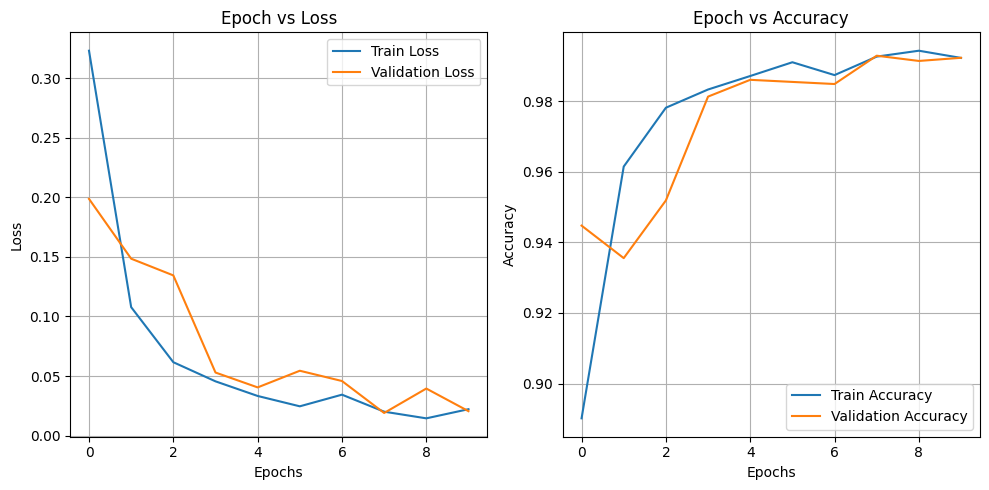

Testing: 100%|██████████| 18/18 [15:45<00:00, 52.55s/it, Batch Loss=0.00181, Batch Accuracy=1]


Test Metrics:
--------------------------------------------------
Loss      : 0.0204
Accuracy  : 0.9926
Precision : 0.9916
Recall    : 0.9909
F1 Score  : 0.9912
ROC AUC   : 0.9924
Metrics for class 0:
  Precision : 0.9936
  Recall    : 0.9455
  F1 Score  : 0.9689
  ROC AUC   : 0.9722
--------------------
Metrics for class 1:
  Precision : 0.9905
  Recall    : 0.9874
  F1 Score  : 0.9889
  ROC AUC   : 0.9918
--------------------
Metrics for class 2:
  Precision : 0.9916
  Recall    : 1.0000
  F1 Score  : 0.9958
  ROC AUC   : 0.9777
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       165
           1       0.99      0.99      0.99       317
           2       0.99      1.00      1.00       944

   micro avg       0.99      0.99      0.99      1426
   macro avg       0.99      0.98      0.98      1426
weighted avg       0.99      0.99      0.99      1426
 samples avg       0.98      0.

In [ ]:
if __name__ == "__main__":
    # Define root directory and sub-folder name
    # root_dir = '/content/drive/Othercomputers/My Mac/DSI_research'
    root_dir = '/content/drive/MyDrive'
    sub_folder = 'dataset'
    num_classes=3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Run the main function
    main(root_dir, sub_folder,10)